## Config

In [61]:
import polaris as po
from polaris.hub.client import PolarisHubClient

import matplotlib.pyplot as plt
import seaborn as sns

from utils import evaluate_gp

import pickle
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Set up Seaborn plotting style
sns.set_style("darkgrid",
              {"axes.facecolor": ".95",
               "axes.edgecolor": "#000000",
               "grid.color": "#EBEBE7",
               "font.family": "serif",
               "axes.labelcolor": "#000000",
               "xtick.color": "#000000",
               "ytick.color": "#000000",
               "grid.alpha": 0.4 })
sns.set_palette('muted')

In [3]:
client = PolarisHubClient()
client.login()

dataset = po.load_dataset("polaris/adme-fang-1")
benchmark = po.load_benchmark("polaris/adme-fang-SOLU-1")

2025-01-14 09:31:50.822 | SUCCESS  | polaris.hub.client:login:268 - You are successfully logged in to the Polaris Hub.


⠼ Fetching dataset... 

2025-01-14 09:31:52.206 | INFO     | polaris._artifact:_validate_version:84 - The version of Polaris that was used to create the artifact (0.0.0) is different from the currently installed version of Polaris (0.9.1).
2025-01-14 09:31:52.210 | INFO     | polaris.mixins._checksum:verify_checksum:65 - To verify the checksum, we need to recompute it. This can be slow for large datasets.


✅ SUCCESS: Fetched dataset.
 
⠙ Fetching artifact... 

/home/wvir/miniconda3/envs/polaris/lib/python3.12/site-packages/yaspin/core.py:171: UserWarning: color, on_color and attrs are not supported when running in jupyter
  self._color = self._set_color(value) if value else value


⠋ Fetching dataset...  

2025-01-14 09:31:53.276 | INFO     | polaris._artifact:_validate_version:84 - The version of Polaris that was used to create the artifact (0.0.0) is different from the currently installed version of Polaris (0.9.1).
2025-01-14 09:31:53.281 | INFO     | polaris.mixins._checksum:verify_checksum:65 - To verify the checksum, we need to recompute it. This can be slow for large datasets.
/home/wvir/miniconda3/envs/polaris/lib/python3.12/site-packages/yaspin/core.py:171: UserWarning: color, on_color and attrs are not supported when running in jupyter
  self._color = self._set_color(value) if value else value
2025-01-14 09:31:53.308 | INFO     | polaris._artifact:_validate_version:84 - The version of Polaris that was used to create the artifact (0.0.0) is different from the currently installed version of Polaris (0.9.1).
2025-01-14 09:31:53.312 | WARNING  | polaris.mixins._checksum:verify_checksum:58 - No checksum to verify against. Specify either the md5sum parameter or store the checksum in 

✅ SUCCESS: Fetched dataset.
 
✅ SUCCESS: Fetched artifact.
 


## Evaluation

In [4]:
# Get data from Polaris benchmark
train, test = benchmark.get_train_test_split()

smiles_train = train.X
y_train = train.y
smiles_test = test.X

In [10]:
means, vars, results, tlls = {}, {}, {}, {}

sizes = [256, 512, 1024, 2048]
fps = ['ecfp', 'fcfp', 'topological', 'atompair']

In [11]:
for fp in fps:
    for size in sizes:
        key = fp + '-' + str(size)
        mean, var, tll = evaluate_gp(smiles_train, y_train, smiles_test, fp_type=fp, sparse=False, fpSize=size)

        means[key], vars[key], tlls[key] = mean, var, tll
        results[key] = benchmark.evaluate(mean)

    key = fp + '-sparse'
    mean, var, tll = evaluate_gp(smiles_train, y_train, smiles_test, fp_type=fp)

    means[key], vars[key], tlls[key] = mean, var, tll
    results[key] = benchmark.evaluate(mean)

Start MLL: -1891.721923828125
End MLL (after optimization): -1530.4366455078125
End GP parameters (after optimization): TanimotoGP_Params(raw_amplitude=Array(-0.00059817, dtype=float32), raw_noise=Array(-0.94969547, dtype=float32))
Start MLL: -1909.451416015625
End MLL (after optimization): -1532.201904296875
End GP parameters (after optimization): TanimotoGP_Params(raw_amplitude=Array(-0.00417468, dtype=float32), raw_noise=Array(-0.95824724, dtype=float32))
Start MLL: -1923.405029296875
End MLL (after optimization): -1540.7352294921875
End GP parameters (after optimization): TanimotoGP_Params(raw_amplitude=Array(-0.00574401, dtype=float32), raw_noise=Array(-0.96089876, dtype=float32))
Start MLL: -1927.118896484375
End MLL (after optimization): -1536.787109375
End GP parameters (after optimization): TanimotoGP_Params(raw_amplitude=Array(-0.00732213, dtype=float32), raw_noise=Array(-0.96480393, dtype=float32))
Start MLL: -1935.939208984375
End MLL (after optimization): -1543.0654296875


In [13]:
with open('means.pkl', 'wb') as file:
    pickle.dump(means, file)
with open('vars.pkl', 'wb') as file:
    pickle.dump(vars, file)
with open('results.pkl', 'wb') as file:
    pickle.dump(results, file)
with open('tll.pkl', 'wb') as file:
    pickle.dump(tll, file)

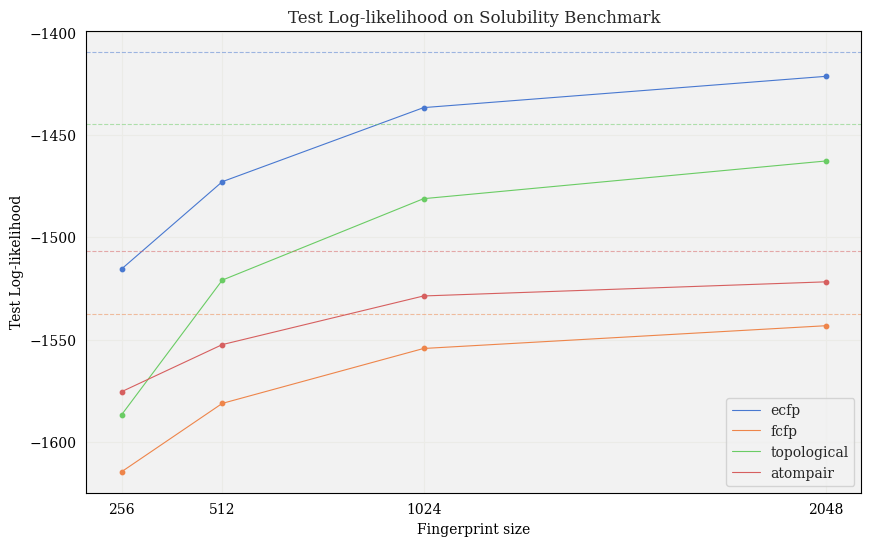

In [62]:
fig, ax = plt.subplots(figsize=(10,6))

for i, label in enumerate(fps):
    
    color = sns.color_palette()[i]

    scores = []
    for s in sizes:
        key = label + '-' + str(s)
        scores.append(tlls[key])
        

    ax.plot(sizes, scores, label=label, lw=.8, c=color)
    ax.axhline(tlls[label + '-sparse'], ls='dashed', lw=.8, c=color, alpha=.5)
    ax.scatter(sizes, scores, s=10, marker='o', c=color)

    ax.set_xticks(sizes)
    ax.set_xticklabels(sizes)

    ax.set_xlabel('Fingerprint size')
    ax.set_ylabel('Test Log-likelihood')
    ax.set_title('Test Log-likelihood on Solubility Benchmark')
    ax.legend()